In [1]:
from src import data_loader as dl
from src.data_loader import PVDataLoader
from src.models import ExactGPModel
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from src.plotting import plot_grid

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Preprocessing Steps

In [22]:
df_location = dl.load_data('pv_data', 'system_location.csv')
df_pv = dl.load_data('pv_data', 'pv.netcdf')

==> Loading data
==> Loaded data in: 0 m : 0 sec

==> Loading data
==> Loaded data in: 19 m : 13 sec



In [3]:
# Set the parameters for data preprocessing
THRESHOLD = 0.05
DAY_MIN = 8
DAY_MAX = 16

In [25]:
df_location = dl.set_index(df_location)

# align pv systems to locations from metadata and the pv data
df_location, df_pv = dl.align_pv_systems(df_location=df_location, 
                                         df_pv=df_pv)

# scale by capacity
df_pv = dl.scale_by_capacity(df_pv, df_location)

# drop systems producing over night
df_pv = dl.drop_night_production(df_pv=df_pv,
                                 threshold=THRESHOLD)

# get daily production from 8am to 4pm
df_pv = dl.daily_production(df_pv=df_pv,
                            day_min=DAY_MIN,
                            day_max=DAY_MAX)

# remove systems with zero production for more than 5 percent of the time
df_pv = dl.remove_zero_production(df_pv=df_pv,
                                  thresh=THRESHOLD)


Dropping 54 systems producing over night


In [26]:
datetime = df_pv.index
df_pv = df_pv.reset_index(drop=True)

df_location, df_pv = dl.align_pv_systems(df_pv=df_pv,
                                         df_location=df_location)
df_pv['datetime'] = datetime

In [27]:
dl.save_csv(df_pv, 'pv_data', 'pv_data_clean.csv')
dl.save_csv(df_location, 'pv_data', 'location_data_clean.csv')

## Example of using preprocessed data

In [2]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.7
COORDS = (54.85074, -1.5278)

In [3]:
df_pv = dl.load_data('pv_data', 'pv_data_clean.csv')
df_location = dl.load_data('pv_data', 'location_data_clean.csv')

==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [4]:
df_location = dl.set_index(df_location)
datetime = df_pv['datetime']

In [5]:
systems = dl.find_nearby_systems(df_location, 
                                     lat=COORDS[0],
                                     lon=COORDS[1],
                                     radius=RADIUS)

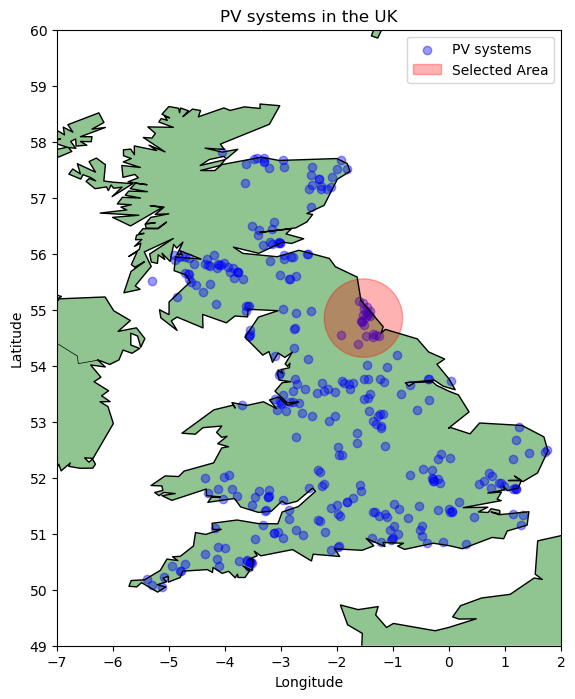

In [6]:
from src.plotting import plot_grid
plot_grid(df_location, COORDS, RADIUS)

In [7]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=10,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')



==> Loading data
==> Loaded data in: 0 m : 7 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



In [255]:
time, y = loader.get_time_series()

time = torch.arange(0, len(time), dtype=torch.float32).unsqueeze(-1)

In [256]:
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)

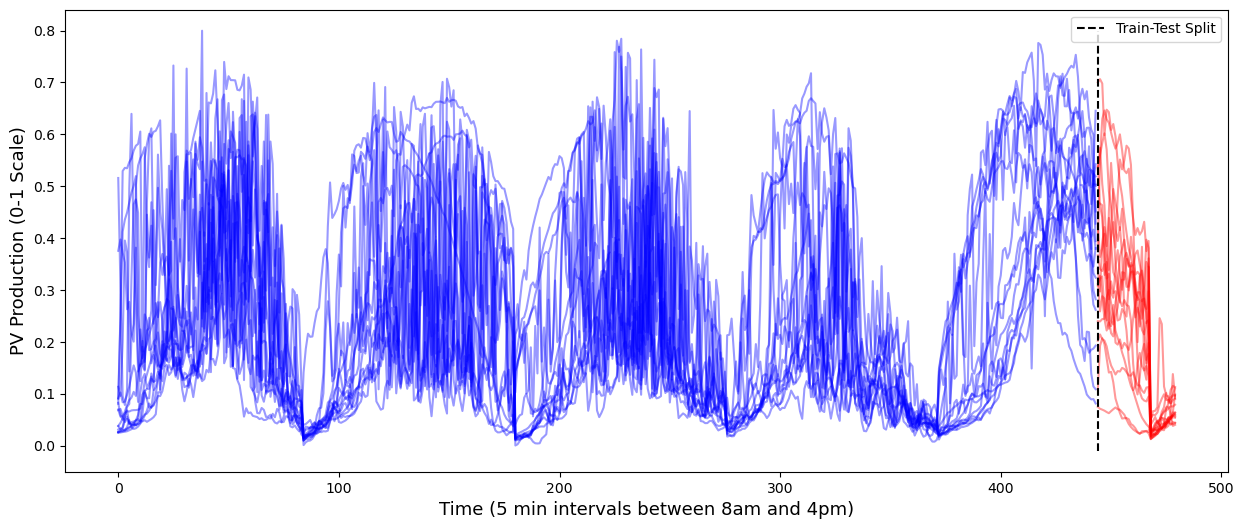

In [257]:
# set figure size
plt.figure(figsize=(15, 6))

# plot the training and test data
plt.plot(time_train, y_train, color='b', alpha=0.4)
plt.plot(time_test, y_test, color='r', alpha=0.4)

# plot the train-test split cutoff
plt.vlines( x= time_train[0] + len(time_train), 
            ymin=-0.01, 
            ymax=max(y_train.max(), y_test.max()), 
            label='Train-Test Split', 
            color='black', 
            linestyle='--')

plt.xlabel('Time (5 min intervals between 8am and 4pm)', fontsize=13)
plt.ylabel('PV Production (0-1 Scale)', fontsize=13)
plt.legend()
plt.show();

# Stochastic Variational Inference for Gaussian Processes

In [260]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy 
from gpytorch.likelihoods import BetaLikelihood
from gpytorch.kernels import MaternKernel, ScaleKernel, RBFKernel
from gpytorch.means import ConstantMean
from gpytorch.distributions import MultivariateNormal
import torch
import gpytorch

class ApproximateGPBaseModel(ApproximateGP):
    """ 
    Base model for performing inference with a Gaussian Process using
    stochastic variational inference with inducing points

    Args:
        train_x (torch.Tensor): training data
        likelihood (gpytorch.likelihoods.Likelihood): likelihood
    """

    def __init__(self, train_x : torch.Tensor, likelihood : gpytorch.likelihoods.Likelihood):
        
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = VariationalStrategy(self, train_x, variational_distribution) 
        
        super(ApproximateGPBaseModel, self).__init__(variational_strategy)
        
        dims = 1 if len(train_x.shape) == 1 else train_x.shape[1]
        
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=dims))

        self.likelihood = likelihood
    
    def forward(self, x):
        """ 
        Model prediction of the GP model

        Args:
            x (torch.Tensor): input data
        
        Returns:
            latent_u (gpytorch.distributions.MultivariateNormal): GP model 
                                                                   f(x), where f ~ GP( m(x), k(x, x))
        """
        mu = self.mean_module(x)
        k = self.covar_module(x, x)
      
        latent_u = MultivariateNormal(mu, k)

        return latent_u
        
    def fit(self, n_iter : int, lr : float, optim : torch.optim.Optimizer, device : torch.device, verbose : bool = True):
        """
        Train the GP model using SVI

        Args:
            n_iter (int): number of iterations
            lr (float): learning rate
            optim (str): optimizer
            device (torch.device): device to train on
            verbose (bool): whether to print training progress
        """
        self.to(device)
        
        self.train()
        self.likelihood.train()

        optimizer = optim(self.parameters(), lr=lr)

        elbo = gpytorch.mlls.VariationalELBO(likelihood=self.likelihood, 
                                            model=self, 
                                            num_data=self.y.size(0))
        
        print_freq = n_iter // 10
        
        for i in range(n_iter):
            optimizer.zero_grad()
            output = self(self.X)
            loss = -elbo(output, self.y)
            loss.backward()
            optimizer.step()

            if verbose and (i+1) % print_freq == 0:
                print(f'Iter {i+1}/{n_iter} - Loss: {loss.item():.3f}')
    
    
    def predict(self, X : torch.Tensor, device : torch.device):
        """ 
        Make predictions with the GP model

        Args:
            X (torch.Tensor): test data
            device (torch.device): device to make predictions on

        Returns:
            preds (gpytorch.distributions.MultivariateNormal): predictive mean and variance
        """
        self.eval()
        self.likelihood.eval()
        
        self.to(device)
        self.likelihood.to(device)

        with torch.no_grad():
            preds = self.likelihood(self(X))
            
        return preds

class BetaGP(ApproximateGPBaseModel):
    """ 
    Stochastic Variational Inference GP model for regression using
    inducing points for scalability and a Beta likelihood for bounded outputs
    in the range [0, 1]

    Args:
        inducing_points (torch.Tensor): inducing points
        variational_dist (gpytorch.variational.VariationalDistribution): variational distribution
        mean_module (gpytorch.means.Mean): mean module
        covar_module (gpytorch.kernels.Kernel): covariance module
    """
    # inherits init from ApproximateGPBaseModel but adds X and y to input when initializing
    def __init__(self, X : torch.Tensor, y : torch.Tensor):
        super(BetaGP, self).__init__(X, BetaLikelihood(scale_constraint=gpytorch.constraints.Interval(0, 1)))
        self.X = X
        self.y = y



In [261]:
model = BetaGP(X=time_train, y=y_train[:,0])
model.fit(n_iter=100, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))

Iter 10/100 - Loss: -0.054


/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-07 to the diagonal
  warnings.warn(
/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


NotPSDError: Matrix not positive definite after repeatedly adding jitter up to 1.0e-06.

In [221]:
pred_train = model(time_train)
pred_test = model(time_test)

In [251]:
from src.plotting import plot_gp_predictions
with torch.no_grad():
    plot_gp_predictions(pred_train + 5, pred_test + 5, time_train.detach().numpy(), time_test.detach().numpy(), y_train[:,0], y_test[:,0])

ImportError: cannot import name 'plot_gp_predictions' from 'src.plotting' (/Users/eirikbaekkelund/Desktop/UCL/Code/Dissertation/src/plotting.py)

# Baselines

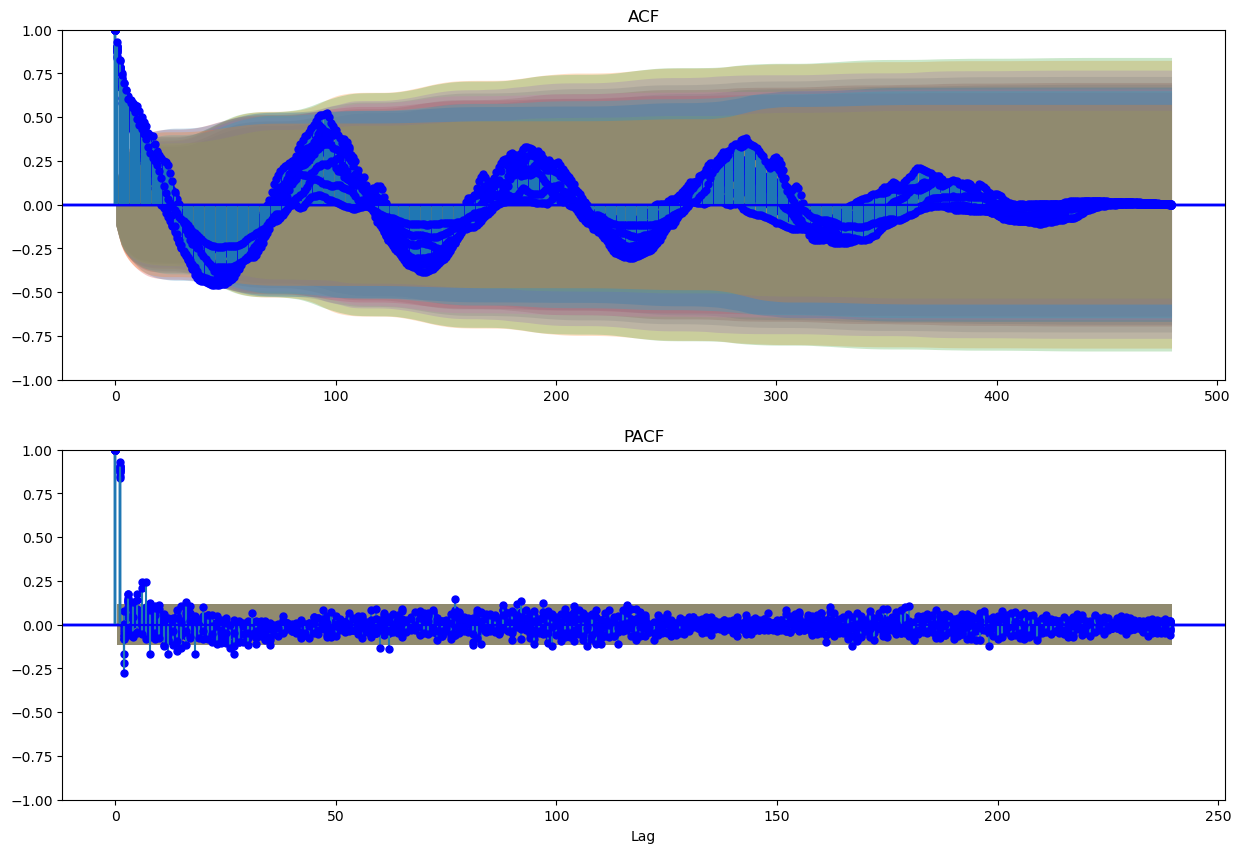

In [66]:
# create function for plotting acf and pacf for all systems in a grid
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def plot_acf_pacf(y):
    """
    Plot the acf and pacf for all systems in a grid
    """
    _, ax = plt.subplots(2, 1, figsize=(15, 10))
    for i in range(y.shape[1]):
        plot_acf(y[:, i], ax=ax[0], alpha=0.01, lags=len(y) - 1, title='ACF', color='b')
        plot_pacf(y[:, i], ax=ax[1], alpha=0.01, lags=len(y) // 2 - 1, title='PACF', color='b', method='ywm')
    
    plt.xlabel('Lag')
    
    plt.show()

plot_acf_pacf(y)
    


# TODO!! Decide how to use ACF / PACF on selecting amount of data to GP Model & Time Series Models

In [ ]:
from statsmodels.tsa.api import AutoReg, ARIMA, SARIMAX, ExponentialSmoothing, MarkovAutoregression


class TimeSeriesForecastingModel:
    """ 
    Global class for time series forecasting models
    
    Args:
        time_train (torch.Tensor): training time
        y_train (torch.Tensor): training data
        time_test (torch.Tensor): test time
        y_test (torch.Tensor): test data
    """
    def __init__(self, time_train, y_train, time_test, y_test):
        self.time_train = time_train
        self.y_train = y_train
        self.time_test = time_test
        self.y_test = y_test
    
    def exponential_smoothing(self, **kwargs):
        """
        Exponential smoothing model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def arima(self, **kwargs):
        """
        ARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarima(self, **kwargs):
        """
        SARIMA model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def sarimax(self, **kwargs):
        """
        SARIMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def var(self, **kwargs):
        """
        VAR model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    def varmax(self, **kwargs):
        """
        VARMAX model
        
        Args:
            **kwargs: keyword arguments for the model
        """
        raise NotImplementedError
    
    
    